<a href="https://colab.research.google.com/github/gitchiba/helloworld/blob/master/Detectron2_TACO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Detectron2 Set up

In [3]:
# install dependencies
!pip install -U torch torchvision cython
!pip install -U 'git+https://github.com/facebookresearch/fvcore.git' 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 24.0 MB/s eta 0:00:00
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.12
    Uninstalling Cython-3.0.12:
      Successfully uninstalled Cython-3.0.12
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-4r7kyzb_
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-4r7kyzb_
  Resolved https://github.com/facebookresearch/fvcore.git to commit a491d5b9a06746f387aca2f1f9c7c7f28e20bef9
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-6g_mi4w2
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-6g_mi4w2
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

'2.7.0+cu126'

In [37]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install detectron2

fatal: destination path 'detectron2_repo' already exists and is not an empty directory.


# Taco dataset set up

In [7]:
!git clone https://github.com/pedropro/TACO.git
!cd TACO
!python3 TACO/download.py --dataset_path TACO/data/annotations.json

Cloning into 'TACO'...
remote: Enumerating objects: 740, done.
remote: Counting objects: 100% (435/435), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 740 (delta 416), reused 380 (delta 380), pack-reused 305 (from 1)
Receiving objects: 100% (740/740), 97.48 MiB | 22.63 MiB/s, done.
Resolving deltas: 100% (499/499), done.
Note. If for any reason the connection is broken. Just call me again and I will start where I left.
Finished


# Imports

In [9]:
import numpy as np
import os
from tqdm import tqdm
import os, json, cv2, random
import pandas as pd
import matplotlib.pyplot as plt
import copy
plt.rcParams.update({'font.size': 22})

# Taco dataset read and viewing

In [12]:
%ls TACO/data

all_image_urls.csv           batch_10/  batch_14/  batch_4/  batch_8/
annotations.json             batch_11/  batch_15/  batch_5/  batch_9/
annotations_unofficial.json  batch_12/  batch_2/   batch_6/
batch_1/                     batch_13/  batch_3/   batch_7/


In [13]:
dataset_path = './TACO/data'
anns_file_path = dataset_path + '/' + 'annotations.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)

In [14]:
img_df=pd.DataFrame(imgs)
ang_df=pd.DataFrame(anns)
cat_df=pd.DataFrame(categories)
print('Number of super categories:',len(cat_df.supercategory.unique()))
print('Number of categories:',len(cat_df.name.unique()))
print('Number of annotations:', len(ang_df))
print('Number of images:', len(img_df))

img_df.head()

Number of super categories: 28
Number of categories: 60
Number of annotations: 4784
Number of images: 1500


,id,width,height,file_name,license,flickr_url,coco_url,date_captured,flickr_640_url
0,0,1537,2049,batch_1/000006.jpg,None,https://farm66.staticflickr.com/65535/33978196...,None,None,https://farm66.staticflickr.com/65535/33978196...
1,1,1537,2049,batch_1/000008.jpg,None,https://farm66.staticflickr.com/65535/47803331...,None,None,https://farm66.staticflickr.com/65535/47803331...
2,2,1537,2049,batch_1/000010.jpg,None,https://farm66.staticflickr.com/65535/40888872...,None,None,https://farm66.staticflickr.com/65535/40888872...
3,3,2049,1537,batch_1/000019.jpg,None,https://farm66.staticflickr.com/65535/47803331...,None,None,https://farm66.staticflickr.com/65535/47803331...
4,4,1537,2049,batch_1/000026.jpg,None,https://farm66.staticflickr.com/65535/33978199...,None,None,https://farm66.staticflickr.com/65535/33978199...


In [16]:
#Cut duplicates
val,counts=np.unique(ang_df.id,return_counts=True)
val[counts>1]

array([ 309, 4040])

In [17]:
ang_df[ang_df.id.duplicated()]

,id,image_id,category_id,segmentation,area,bbox,iscrowd
309,309,101,5,"[[1410, 1396, 1552, 1349, 1610, 1346, 1623, 13...",26957.0,"[1370.0, 1291.0, 380.0, 150.0]",0
4040,4040,1300,58,"[[143, 1979, 187, 1980, 184, 2028, 158, 2028, ...",1798.5,"[143.0, 1979.0, 44.0, 49.0]",0


In [18]:
ang_df=ang_df[~ang_df.id.duplicated(keep="first")]

<Axes: ylabel='Frequency'>

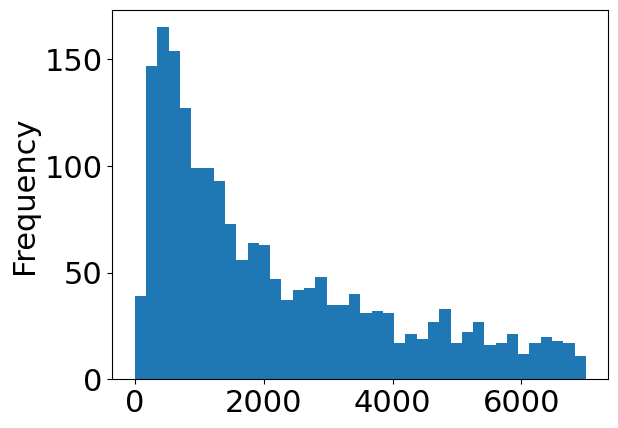

In [19]:
ang_df["area"].plot.hist(range=(0,7000),bins=40)

In [20]:
import colorsys
from ipywidgets import interact

def get_optimal_font_scale(text, width):
    #Source https://stackoverflow.com/questions/52846474/how-to-resize-text-for-cv2-puttext-according-to-the-image-size-in-opencv-python

    for scale in reversed(range(0, 60, 1)):
      textSize = cv2.getTextSize(text, fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=scale/10, thickness=1)
      new_width = textSize[0][0]
      #print(new_width)
      if (new_width <= width):
          return scale/10
    return 1



def CV2_SegBBoxClassImshow(image,n_bbox,n_segs,n_classes,ax=None,bbox_type="XYWH",figsize=(10,10)):
    #Add to subplot or create new plot
    if not ax:
        fig,ax=plt.subplots(1,1,figsize=figsize)
    #copy image, make sure its an array
    new_image=np.array(image)


    #Add bbox and segmentations in look
    for box,seg,cat in zip(n_bbox,n_segs,n_classes):

        c=colorsys.hsv_to_rgb(np.random.random(),1,255)

        #print(c)
        # = ( int (c [ 0 ]), int (c[ 1 ]), int (c [ 2 ]))
        box=np.array(box,dtype=np.int32)
        #bbox type XXWH
        if bbox_type=="XYWH": #(x0,y0,w,h)
            new_image=cv2.rectangle(new_image,
                        (box[0],box[1]),
                        (box[0]+box[2],box[1]+box[3]),
                        c,
                        thickness=5
                        )
        else: #XYXY
            new_image=cv2.rectangle(new_image,
                         (box[0],box[1]),
                        (box[2],box[3]),
                        c,
                        thickness=5
                        )

        pl=len(seg)
        #ALpha effect for fillpoly
        seg=np.array(seg,dtype=np.uint64).reshape(1, -1, 2)
        overlay=new_image.copy()
        cv2.fillPoly(overlay,seg,c) #Add segmentation

        scale=get_optimal_font_scale(cat, box[2]) #Text scaling to BBox width
        cv2.putText(new_image,cat, (box[0],box[1]),cv2.FONT_HERSHEY_PLAIN, scale,c,cv2.LINE_AA)


        new_image=cv2.addWeighted(overlay,0.4,new_image,1-0.4,0)


    #Show image
    ax.imshow(new_image[:,:,::-1])
    ax.set_title(f"image {new_image.shape}, BBoxs {len(n_bbox)}")





data_dic=dataset
#Interactive plot by images id
@interact(image_idx=(0, len(data_dic["images"])))
def DataDict_intract_view(image_idx):
    img_d=data_dic["images"][image_idx]
    id=img_d["id"]

    img=cv2.imread(dataset_path+"/"+img_d["file_name"]) #Read image

    #Get annotations
    annot=list([ a for a in data_dic["annotations"] if a["image_id"]==id ])
    #segs=np.array(list([a["segmentation"] for a in annot]))
    n_bbox=list([a["bbox"] for a in annot])
    n_segs=list([a['segmentation'] for a in annot])
    #n_classes=list([a['category_id'] for a in annot])
    #Class names
    n_classes=[ cat_df.iloc[annot[i]["category_id"]].supercategory for i in range(0, len(annot))]
    #print(n_bbox)
    CV2_SegBBoxClassImshow(img,n_bbox,n_segs,n_classes,bbox_type="XYWH")

interactive(children=(IntSlider(value=750, description='image_idx', max=1500), Output()), _dom_classes=('widge…

# Taco Dataset to COCO

Format data ready for detectron
* category ids -> super catergorys
* add bbox type
* create json from train and evaluations
* Save as COCO dataset

In [21]:
#Super catergoires
ang_df["super_category"]=ang_df["category_id"].apply(lambda value: categories[value]["supercategory"] )
super_categorys=[]
ang_df["super_category_id"]=0
for i,cat in enumerate(sorted(ang_df["super_category"].unique())):
    super_categorys.append({"name":cat,"id":i})
    ang_df.loc[ang_df["super_category"]==cat,"super_category_id"]=i
ang_df["category_id"]=ang_df["super_category_id"]

<Axes: ylabel='val'>

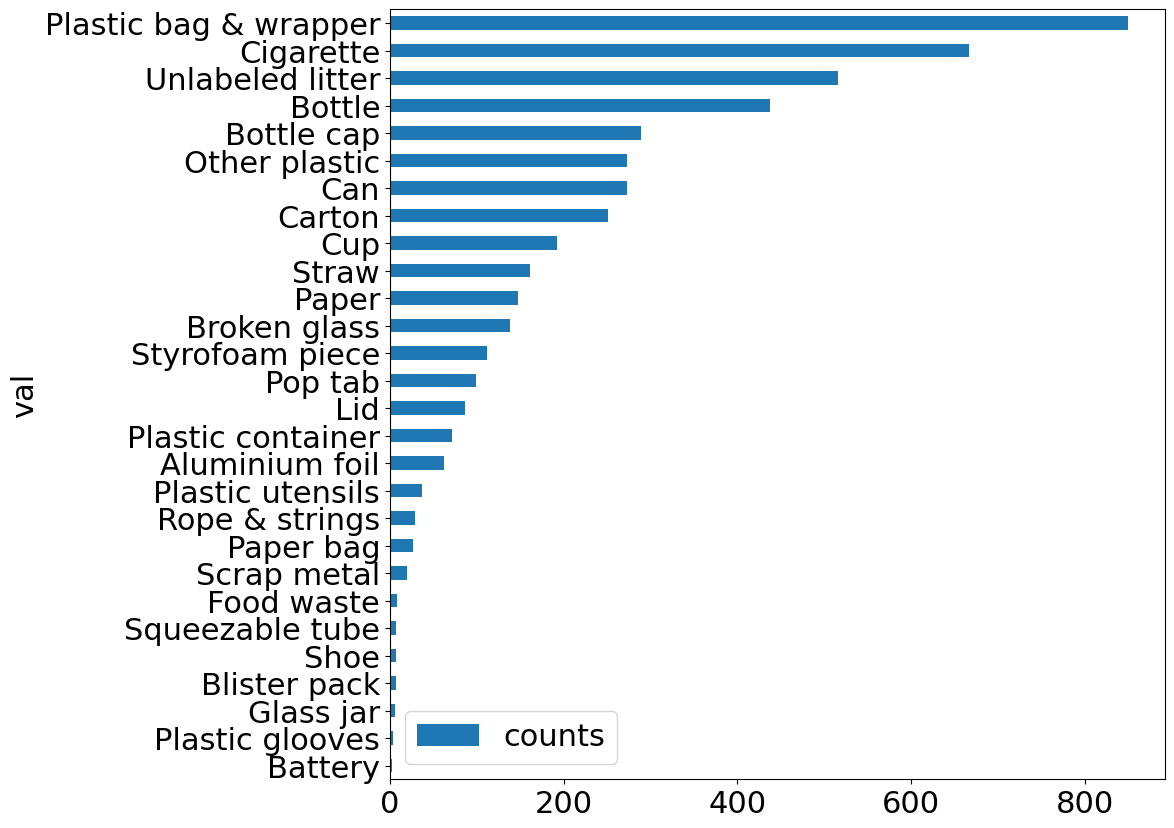

In [22]:
#Category label number plot
vals,counts=np.unique(ang_df["super_category"],return_counts=True)
cat_count_df=pd.DataFrame(data={"val":vals,"counts":counts})
cat_count_df=cat_count_df.sort_values("counts")


cat_count_df.plot.barh(x="val",figsize=(10,10))

Text(0, 0.5, 'Frequency')

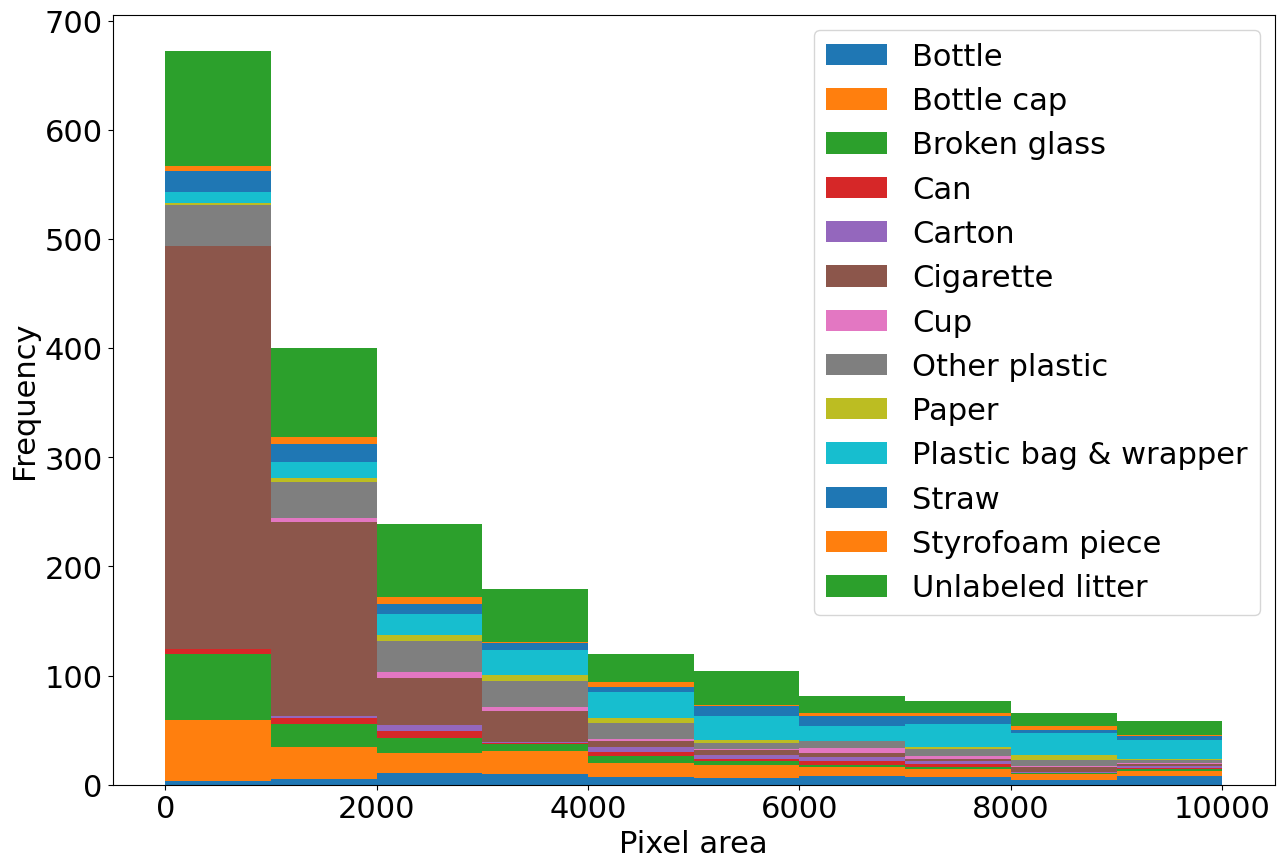

In [23]:
#Category label plot historam, many (100>) and few (100<)

cats100P=list(cat_count_df[cat_count_df["counts"]>100].val)
cats100L=list(cat_count_df[cat_count_df["counts"]<100].val)
stacks_P100=[]
labels_P100=[]

stacks_L100=[]
labels_L100=[]

for g, item in ang_df.groupby("super_category"):
    if g in cats100P:
        stacks_P100.append(item["area"].values)
        labels_P100.append(g)
    else:
        stacks_L100.append(item["area"].values)
        labels_L100.append(g)

plt.figure(figsize=(15,10))
plt.hist(stacks_P100,bins=10,histtype="barstacked",label=labels_P100,range=(0, 10000))
plt.legend()
plt.xlabel("Pixel area")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

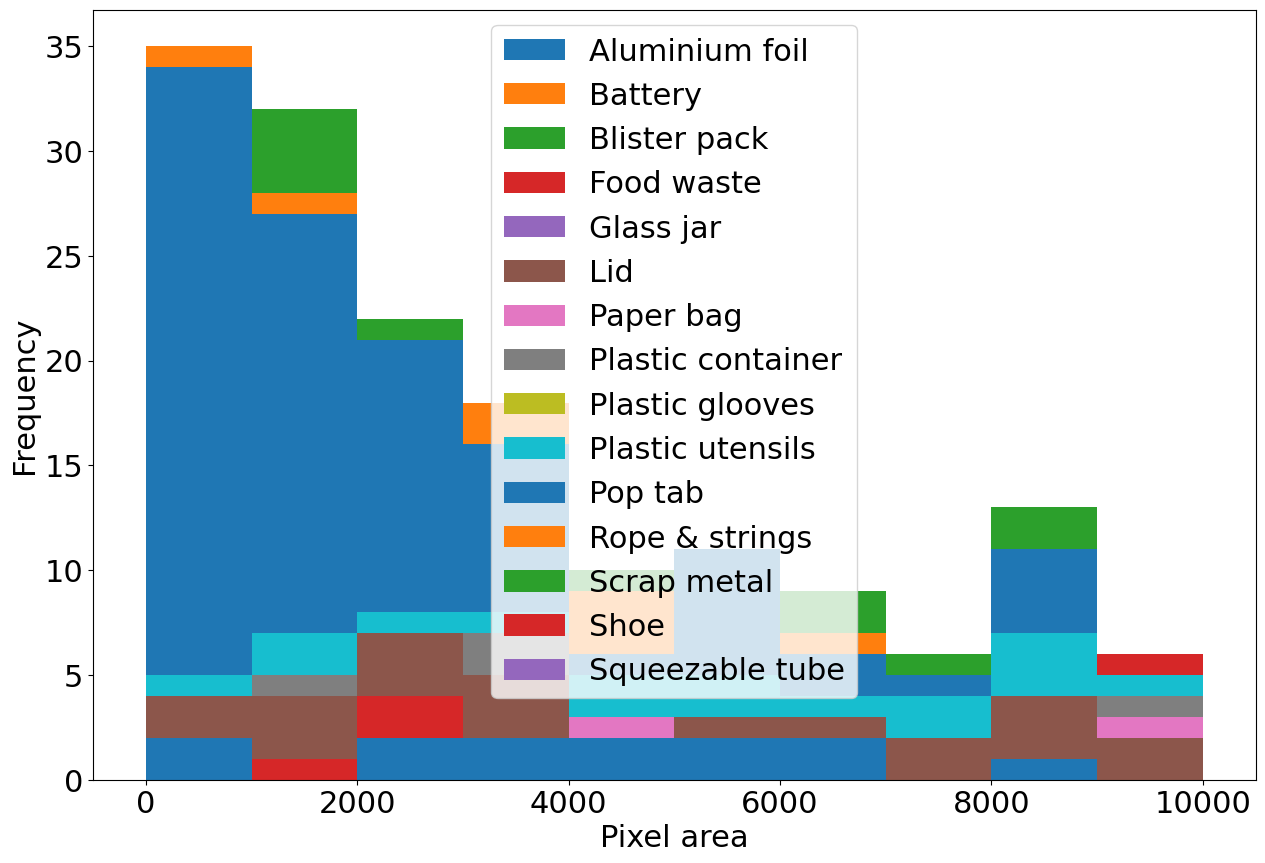

In [24]:
plt.figure(figsize=(15,10))
plt.hist(stacks_L100,bins=10,histtype="barstacked",label=labels_L100,range=(0, 10000))
plt.legend()
plt.xlabel("Pixel area")
plt.ylabel("Frequency")

In [38]:
%ls

detectron2_repo/  drive/  sample_data/  TACO/


In [39]:
#BBOx mode
from detectron2.structures import BoxMode

ang_df["bbox_mode"]=BoxMode.XYWH_ABS


cocodata={"images":img_df[["id","width","height","file_name"]].to_dict("records"),#Cut index
         "annotations":ang_df[['id', 'image_id', 'category_id', 'segmentation', 'area', 'bbox',
       'iscrowd', 'bbox_mode']].to_dict("records"),
          "categories":super_categorys, "info":dataset["info"]}


cocodata={"images":img_df[["id","width","height","file_name"]].to_dict("records"),#Cut index
         "annotations":ang_df[['id', 'image_id', 'category_id', 'segmentation', 'area', 'bbox',
       'iscrowd', 'bbox_mode']].to_dict("records"),
          "categories":super_categorys, "info":dataset["info"]}


ModuleNotFoundError: No module named 'detectron2'

In [ ]:
#Save datadata as json
save_name="TACO_annotations.json"
json.dump(cocodata,open(save_name,"w"))


#Train eval split
img_id=list(range(1,len(cocodata["images"])+1))
np.random.seed=42
import random


def SplitDatadir(data_dict,img_ids):
    newdata_dict=copy.deepcopy(data_dict) #.copy()
    print("start",len(newdata_dict["images"]),len(newdata_dict["annotations"]))
    #newdata_dict["images"]={}
    #newdata_dict["annotations"]={}
    newdata_dict["images"]=list(img for img in data_dict["images"] if img["id"] in img_ids)

    newdata_dict["annotations"]=list(ann for ann in data_dict["annotations"] if ann['image_id'] in img_ids)

    print("finish",len(newdata_dict["images"]),len(newdata_dict["annotations"]))
    return newdata_dict

#Split data set by 80% train, 20% eval
train_id=random.sample(img_id,int((len(img_id))*0.8))
val_id=list([id for id in img_id if id not in train_id])
print(len(train_id),len(val_id))

train_dataset=SplitDatadir(cocodata,train_id)
json.dump(train_dataset,open(save_name.replace(".","_train."),"w"))
val_dataset=SplitDatadir(cocodata,val_id)
json.dump(val_dataset,open(save_name.replace(".","_val."),"w"))

1200 300
start 1500 4782
finish 1200 3763
start 1500 4782
finish 299 1018


In [ ]:

#Load data set into COCO
image_root=dataset_path
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
label_paths={
   "train":save_name.replace(".","_train."),
   "val":save_name.replace(".","_val."),
    "all":save_name  #label_path,
}
for d in list(label_paths.keys()):
  dataset_name=f"TACO_{d}"
  if dataset_name in DatasetCatalog.list():
    #DatasetCatalog.remove()
    DatasetCatalog.clear(dataset_name)
  register_coco_instances(dataset_name, {},label_paths[d], image_root)

NameError: ignored

# Detectron2

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from datetime import datetime

In [ ]:
Models_Segmentation=["COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x",
        "COCO-InstanceSegmentation/mask_rcnn_R_50_DC5_1x",
        "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x",
        "COCO-InstanceSegmentation/mask_rcnn_R_50_C4_3x",
        "COCO-InstanceSegmentation/mask_rcnn_R_50_DC5_3x",
        "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x",
        "COCO-InstanceSegmentation/mask_rcnn_R_101_C4_3x",
        "COCO-InstanceSegmentation/mask_rcnn_R_101_DC5_3x",
        "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x"]

In [ ]:
cfg = get_cfg()
model=Models_Segmentation[7]
cfg.merge_from_file(model_zoo.get_config_file(f"{model}.yaml")) #Get base model
cfg.DATASETS.TRAIN = ("TACO_train",)
cfg.DATASETS.TEST = ("TACO_val",)
cfg.DATALOADER.NUM_WORKERS = 0
cfg.OUTPUT_DIR=f"./output/{model}"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model) #Dafulte weighting

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(super_categorys)

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.SOLVER.MAX_ITER =500
cfg.SOLVER.LR_SCHEDULER_NAME= "WarmupMultiStepLR"  # WarmupMultiStepLR (default) or WarmupCosineLR
cfg.SOLVER.IMS_PER_BATCH =  4
cfg.SOLVER.STEPS = []
cfg.SOLVER.BASE_LR =0.001



start=datetime.today()
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()
end=datetime.today()
modelruntime=end-start

print(f"{'X'*20}")
print(f"{'X'*20}")
print(f"{'X'*5} runtime {'X'*6}")
print(modelruntime.__str__())
print(f"{'X'*20}")
print(f"{'X'*20}")

RuntimeError: ignored

In [ ]:
#Evaluate

from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

eval_name="TACO_val"
evaluator=COCOEvaluator(eval_name, ("bbox","segm"),
                        False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg,eval_name)

evalation=inference_on_dataset(trainer.model, val_loader, evaluator)


In [ ]:
df_evalation=pd.DataFrame(evalation)
df_evalation=df_evalation.drop(["APs","APm","APl"],axis=0)
df_evalation.to_csv(cfg.OUTPUT_DIR+"/evaluation.csv")

fig,ax=plt.subplots(1,1,figsize=(10,10))
df_evalation.plot.bar(rot=90,ax=ax)
ax.grid()
ax.set_ylabel("Average Percision (AP)")
fig.savefig(cfg.OUTPUT_DIR+"/AveragePercion_plot.jpg")


# Predictions

In [ ]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

# create config
cfg = get_cfg()
# below path applies to current installation location of Detectron2
model=Models_Segmentation[7]
cfg.merge_from_file(model_zoo.get_config_file(f"{model}.yaml"))

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.WEIGHTS =  os.path.join("output",model, "model_final.pth")  #"detectron2://COCO-Detection/faster_rcnn_R_101_FPN_3x/137851257/model_final_f6e8b1.pkl"
cfg.MODEL.DEVICE = "cpu" # we use a CPU Detectron copy
cfg.MODEL.ROI_HEADS.NUM_CLASSES =28 #num_of_classes
# classes = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes
predictor = DefaultPredictor(cfg)
print("Predictor has been initialized.")


In [ ]:
ran_img=np.random.choice(imgs)
img=cv2.imread(dataset_path +"/"+ran_img["file_name"])
pred_result = predictor(img)
pred_result

In [ ]:
from detectron2.utils.visualizer import Visualizer
v = Visualizer(img)
out = v.draw_instance_predictions(pred_result['instances'])
plt.figure(figsize=(15,15))
fig=plt.imshow(out.get_image()[:, :, ::-1])

In [ ]:
from ipywidgets import interact
@interact(image_idx=(0, len(imgs)))
def DataDict_intract_view(image_idx):
    img_dir=imgs[image_idx]
    img=cv2.imread(dataset_path +"/"+img_dir["file_name"])
    pred_result = predictor(img)
    v = Visualizer(img)
    out = v.draw_instance_predictions(pred_result['instances'])
    plt.figure(figsize=(10,10))
    fig=plt.imshow(out.get_image()[:, :, ::-1])